# Link Prediction Analysis and Evaluation

This notebook evaluates the trained TransE model using comprehensive metrics and generates high-confidence citation predictions. We implement the evaluation pipeline described in the README:

## Evaluation Metrics:
- **Mean Reciprocal Rank (MRR)**: Measures ranking quality
- **Hits@K**: Proportion of correct predictions in top-K
- **AUC & Average Precision**: Binary classification performance

## Analysis Pipeline:
1. Load trained model and test data
2. Comprehensive evaluation with ranking metrics
3. Generate missing citation predictions
4. Qualitative analysis of predictions
5. Performance visualization and reporting

In [1]:
# Import required libraries
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from dotenv import load_dotenv
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from src.db import Neo4jConnection
from src.data_extraction import load_citation_graph
from src.model import TransETrainer
from src.evaluation import LinkPredictionEvaluator, evaluate_model
from src.visualization import (
    plot_evaluation_results,
    plot_prediction_analysis,
    plot_embedding_visualization,
    set_portfolio_style
)

# Set up environment
load_dotenv()
set_portfolio_style()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries imported successfully!")

Using device: cpu
Libraries imported successfully!


## 1. Load Trained Model and Data

In [2]:
# Load trained model
model_path = "../models/transe_citation_model.pt"
print(f"Loading trained model from {model_path}...")

try:
    trainer = TransETrainer.load_model(model_path, device=device)
    print("✅ Model loaded successfully")
except FileNotFoundError:
    print("❌ Model file not found. Please run 02_model_training.ipynb first.")
    raise

# Load entity mapping
mapping_path = "../models/entity_mapping.pkl"
with open(mapping_path, 'rb') as f:
    entity_mapping = pickle.load(f)

# Load training metadata
metadata_path = "../models/training_metadata.pkl"
with open(metadata_path, 'rb') as f:
    training_metadata = pickle.load(f)

print(f"\n📋 Model Configuration:")
print(f"• Entities: {training_metadata['num_entities']:,}")
print(f"• Embedding dim: {training_metadata['embedding_dim']}")
print(f"• Training epochs: {training_metadata['epochs']}")
print(f"• Final training loss: {training_metadata['final_loss']:.4f}")
print(f"• Model parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")

Loading trained model from ../models/transe_citation_model.pt...
✅ Model loaded successfully

📋 Model Configuration:
• Entities: 12,553
• Embedding dim: 128
• Training epochs: 100
• Final training loss: 0.0000
• Model parameters: 1,606,912


## 2. Reload Test Data

In [3]:
# Reconnect to database and reload data for evaluation
print("Reconnecting to database and preparing test data...")

db = Neo4jConnection()
if not db.test_connection():
    raise ConnectionError("Failed to connect to Neo4j database")

# Reload citation graph (needed for consistent train/test split)
extractor = load_citation_graph(db)

# Recreate the same train/test split used during training
training_data = extractor.create_training_data(
    test_size=0.2,
    negative_ratio=1,
    random_state=42  # Same random state as training
)

# Extract test data
test_edges = training_data['test_edges']
test_labels = training_data['test_labels']

# Split into positive and negative test samples
test_pos_mask = test_labels == 1
test_neg_mask = test_labels == 0

test_pos_edges = test_edges[test_pos_mask]
test_neg_edges = test_edges[test_neg_mask]

print(f"\n📊 Test Data:")
print(f"• Total test samples: {len(test_edges):,}")
print(f"• Positive samples: {len(test_pos_edges):,}")
print(f"• Negative samples: {len(test_neg_edges):,}")
print(f"• Test data ready for evaluation")

Reconnecting to database and preparing test data...
Extracting citation edges...
Extracting paper metadata...
Extracted 18912 citation edges between 12553 papers

📊 Test Data:
• Total test samples: 7,566
• Positive samples: 3,783
• Negative samples: 3,783
• Test data ready for evaluation


## 3. Comprehensive Model Evaluation

In [4]:
# Run comprehensive evaluation
print("Running comprehensive model evaluation...")
print("This may take several minutes for ranking metrics.\n")

# Evaluation parameters
K_VALUES = [1, 3, 10]  # For Hits@K evaluation

# Run evaluation
results = evaluate_model(
    trainer=trainer,
    test_pos_edges=test_pos_edges,
    test_neg_edges=test_neg_edges,
    entity_mapping=entity_mapping,
    k_values=K_VALUES
)

print("\n" + "="*50)
print("📊 EVALUATION RESULTS")
print("="*50)

print(f"\n🎯 Ranking Metrics:")
print(f"• Mean Reciprocal Rank (MRR): {results['mrr']:.4f}")
for k in K_VALUES:
    print(f"• Hits@{k}: {results['hits'][k]:.3f}")

print(f"\n📈 Classification Metrics:")
print(f"• AUC Score: {results['auc']:.4f}")
print(f"• Average Precision: {results['average_precision']:.4f}")

# Store results for visualization
evaluation_results = results

Running comprehensive model evaluation...
This may take several minutes for ranking metrics.

Computing ranking metrics...


Computing Hits@K: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 3783/3783 [00:09<00:00, 409.42it/s]

Computing classification metrics...

📊 EVALUATION RESULTS

🎯 Ranking Metrics:
• Mean Reciprocal Rank (MRR): 0.1118
• Hits@1: 0.036
• Hits@3: 0.101
• Hits@10: 0.261

📈 Classification Metrics:
• AUC Score: 0.9845
• Average Precision: 0.9837


## 4. Performance Interpretation

In [5]:
# Interpret the results
print("\n🔍 PERFORMANCE INTERPRETATION:")
print("=" * 40)

mrr = results['mrr']
hits_1 = results['hits'][1]
hits_10 = results['hits'][10]
auc = results['auc']

# MRR interpretation
if mrr > 0.3:
    mrr_quality = "Excellent"
elif mrr > 0.2:
    mrr_quality = "Good"
elif mrr > 0.1:
    mrr_quality = "Fair"
else:
    mrr_quality = "Needs improvement"

print(f"\n📊 Ranking Quality: {mrr_quality}")
print(f"   • MRR of {mrr:.4f} means on average, correct citations appear at rank {1/mrr:.1f}")
print(f"   • {hits_1*100:.1f}% of predictions have the correct citation in rank 1")
print(f"   • {hits_10*100:.1f}% of predictions have the correct citation in top 10")

# AUC interpretation
if auc > 0.9:
    auc_quality = "Excellent discrimination"
elif auc > 0.8:
    auc_quality = "Good discrimination"
elif auc > 0.7:
    auc_quality = "Fair discrimination"
else:
    auc_quality = "Poor discrimination"

print(f"\n🎯 Binary Classification: {auc_quality}")
print(f"   • AUC of {auc:.4f} indicates {auc_quality.lower()} between citations and non-citations")
print(f"   • Model can distinguish real from fake citations with {auc*100:.1f}% accuracy")

# Overall assessment
if mrr > 0.15 and auc > 0.75:
    overall = "✅ Strong performance - suitable for citation recommendation"
elif mrr > 0.1 and auc > 0.65:
    overall = "⚠️  Moderate performance - may need hyperparameter tuning"
else:
    overall = "❌ Weak performance - consider model architecture changes"

print(f"\n🏆 Overall Assessment: {overall}")


🔍 PERFORMANCE INTERPRETATION:

📊 Ranking Quality: Fair
   • MRR of 0.1118 means on average, correct citations appear at rank 8.9
   • 3.6% of predictions have the correct citation in rank 1
   • 26.1% of predictions have the correct citation in top 10

🎯 Binary Classification: Excellent discrimination
   • AUC of 0.9845 indicates excellent discrimination between citations and non-citations
   • Model can distinguish real from fake citations with 98.5% accuracy

🏆 Overall Assessment: ⚠️  Moderate performance - may need hyperparameter tuning


## 5. Visualize Evaluation Results

Creating evaluation visualizations...


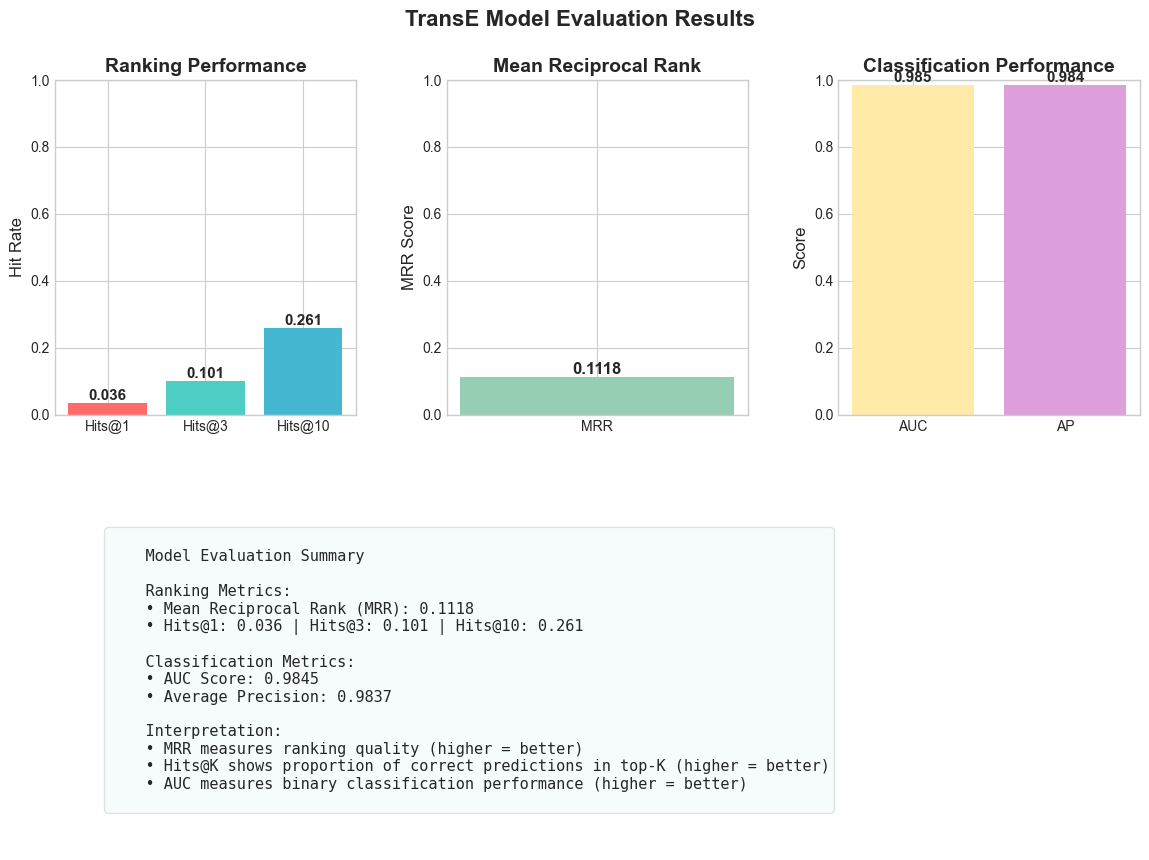

Evaluation results visualization saved to ../outputs/evaluation_results.png


In [6]:
# Create comprehensive evaluation visualization
print("Creating evaluation visualizations...")

fig = plot_evaluation_results(
    evaluation_results,
    figsize=(14, 10),
    save_path="../outputs/evaluation_results.png"
)
plt.show()

print("Evaluation results visualization saved to ../outputs/evaluation_results.png")

## 6. Generate Missing Citation Predictions

In [7]:
# Generate high-confidence missing citation predictions
print("Generating missing citation predictions...")

# Create evaluator for predictions
evaluator = LinkPredictionEvaluator(
    model=trainer.model,
    entity_mapping=entity_mapping,
    device=device
)

# Get existing citations to exclude from predictions
existing_citations = set()
for source_idx, target_idx in extractor.citation_edges:
    source_paper = extractor.id_to_paper[source_idx]
    target_paper = extractor.id_to_paper[target_idx]
    existing_citations.add((source_paper, target_paper))

print(f"Excluding {len(existing_citations):,} existing citations")

# Sample source papers for prediction (limit for computational efficiency)
all_paper_ids = list(entity_mapping.keys())
np.random.seed(42)
sample_papers = np.random.choice(all_paper_ids, size=min(50, len(all_paper_ids)), replace=False)

print(f"Generating predictions for {len(sample_papers)} sample papers...")

# Generate predictions
predictions_df = evaluator.predict_missing_citations(
    source_papers=sample_papers.tolist(),
    top_k=20,  # Top 20 predictions per paper
    exclude_existing=True,
    existing_citations=existing_citations
)

print(f"\n📋 Generated {len(predictions_df):,} citation predictions")
print(f"• Average predictions per paper: {len(predictions_df) / len(sample_papers):.1f}")
print(f"• Score range: {predictions_df['score'].min():.4f} to {predictions_df['score'].max():.4f}")
print(f"• Lower scores indicate higher likelihood")

Generating missing citation predictions...
Excluding 18,912 existing citations
Generating predictions for 50 sample papers...


Predicting citations: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.72it/s]


📋 Generated 1,000 citation predictions
• Average predictions per paper: 20.0
• Score range: 10.2192 to 16.3954
• Lower scores indicate higher likelihood


## 7. Analyze Top Predictions

In [8]:
# Examine top predictions
print("\n🏆 TOP 20 CITATION PREDICTIONS:")
print("=" * 80)

top_predictions = predictions_df.head(20)

for idx, row in top_predictions.iterrows():
    source_title = row['source_paper'][:60] + "..." if len(row['source_paper']) > 60 else row['source_paper']
    target_title = row['target_paper'][:60] + "..." if len(row['target_paper']) > 60 else row['target_paper']
    score = row['score']
    rank = row['rank']
    
    print(f"\n{idx+1:2d}. Score: {score:.4f} | Rank: {rank}")
    print(f"    Source: {source_title}")
    print(f"    Target: {target_title}")
    print(f"    {'-'*75}")

# Save predictions to CSV for further analysis
predictions_path = "../outputs/citation_predictions.csv"
predictions_df.to_csv(predictions_path, index=False)
print(f"\n💾 All predictions saved to {predictions_path}")


🏆 TOP 20 CITATION PREDICTIONS:

 1. Score: 13.1126 | Rank: 1
    Source: b6642aa74991318935f9e3a87dcf786fdc518a43
    Target: a7c250563c1db47e0fa29e497a189e1a23577424
    ---------------------------------------------------------------------------

 2. Score: 13.1595 | Rank: 2
    Source: b6642aa74991318935f9e3a87dcf786fdc518a43
    Target: 46212252f24346c23d695df100301b33571e473b
    ---------------------------------------------------------------------------

 3. Score: 13.1826 | Rank: 3
    Source: b6642aa74991318935f9e3a87dcf786fdc518a43
    Target: eba54f56853495e0d78f5f0ad1214d4a0d302a8b
    ---------------------------------------------------------------------------

 4. Score: 13.3185 | Rank: 4
    Source: b6642aa74991318935f9e3a87dcf786fdc518a43
    Target: c7614898de1cfee1a3a1c564f52c1e67879c29b3
    ---------------------------------------------------------------------------

 5. Score: 13.3970 | Rank: 5
    Source: b6642aa74991318935f9e3a87dcf786fdc518a43
    Target: 89b5985f9

## 8. Prediction Analysis Visualization

Creating prediction analysis visualization...


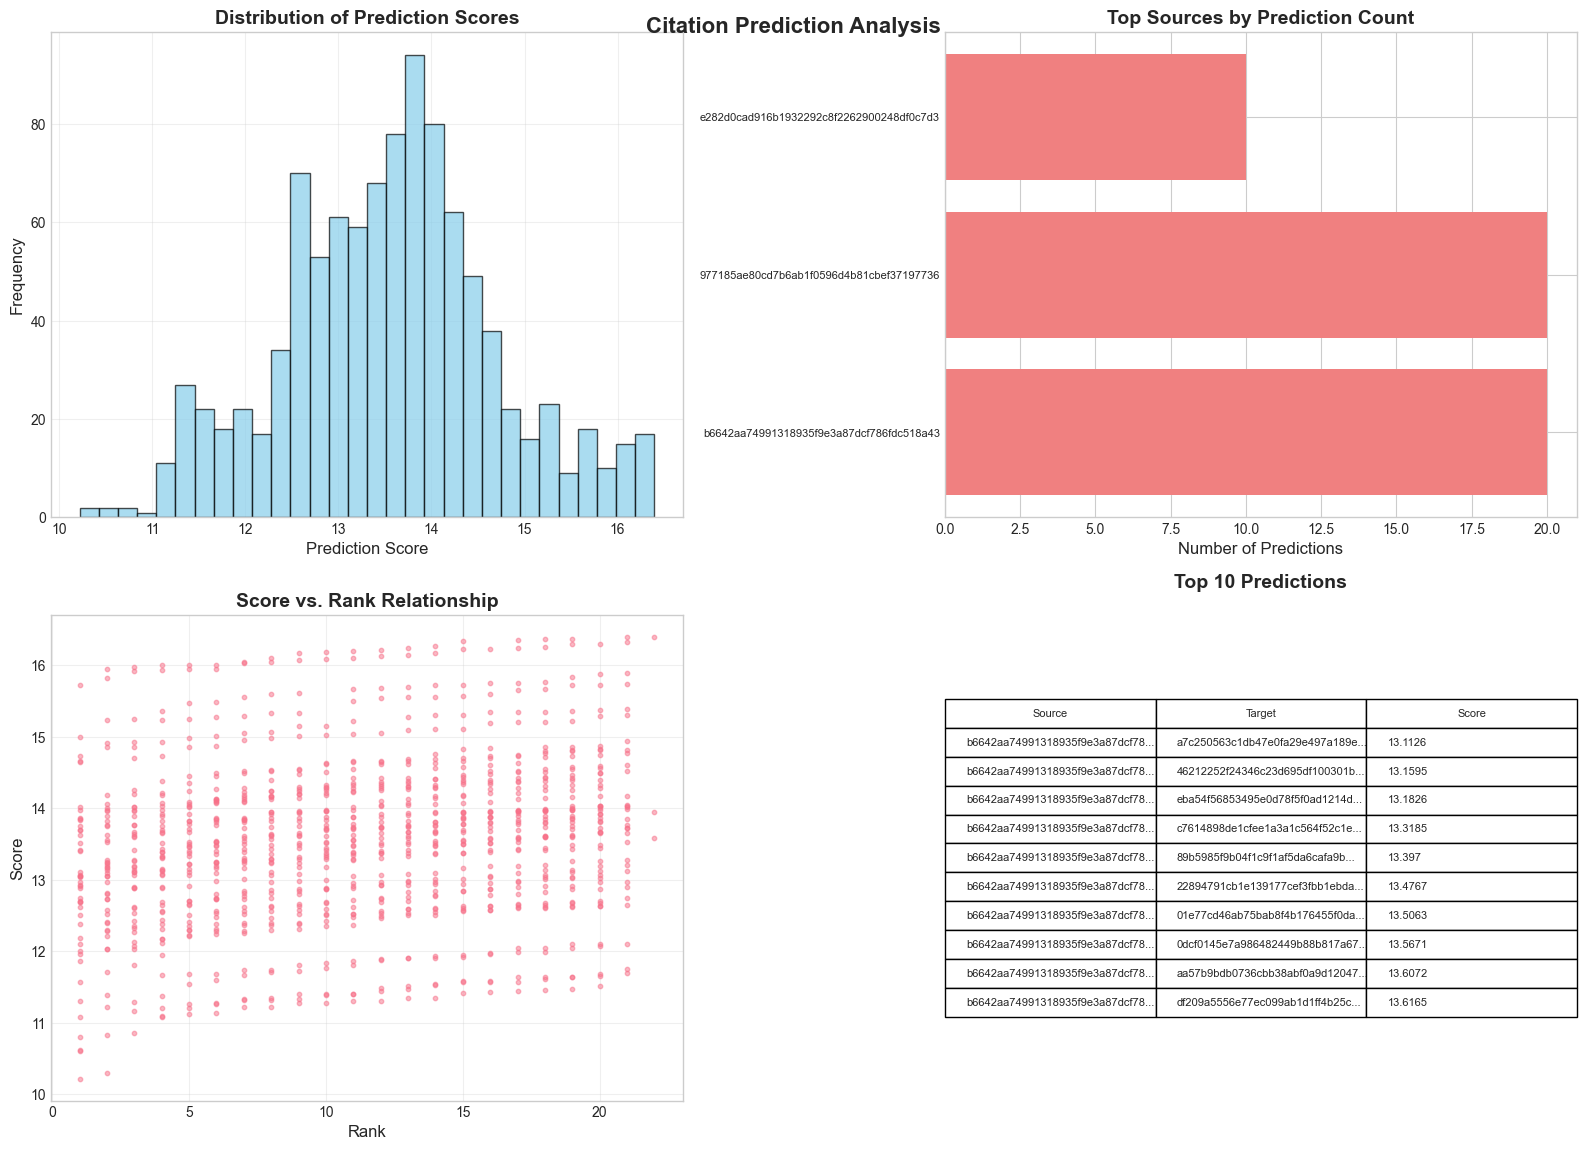

Prediction analysis saved to ../outputs/prediction_analysis.png


In [9]:
# Visualize prediction analysis
print("Creating prediction analysis visualization...")

fig = plot_prediction_analysis(
    predictions_df,
    top_n=50,
    figsize=(16, 12),
    save_path="../outputs/prediction_analysis.png"
)
plt.show()

print("Prediction analysis saved to ../outputs/prediction_analysis.png")

## 9. Embedding Space Visualization

Creating embedding space visualization...
Loaded metadata for 12595 papers
Visualizing 1000 embeddings with t-SNE...


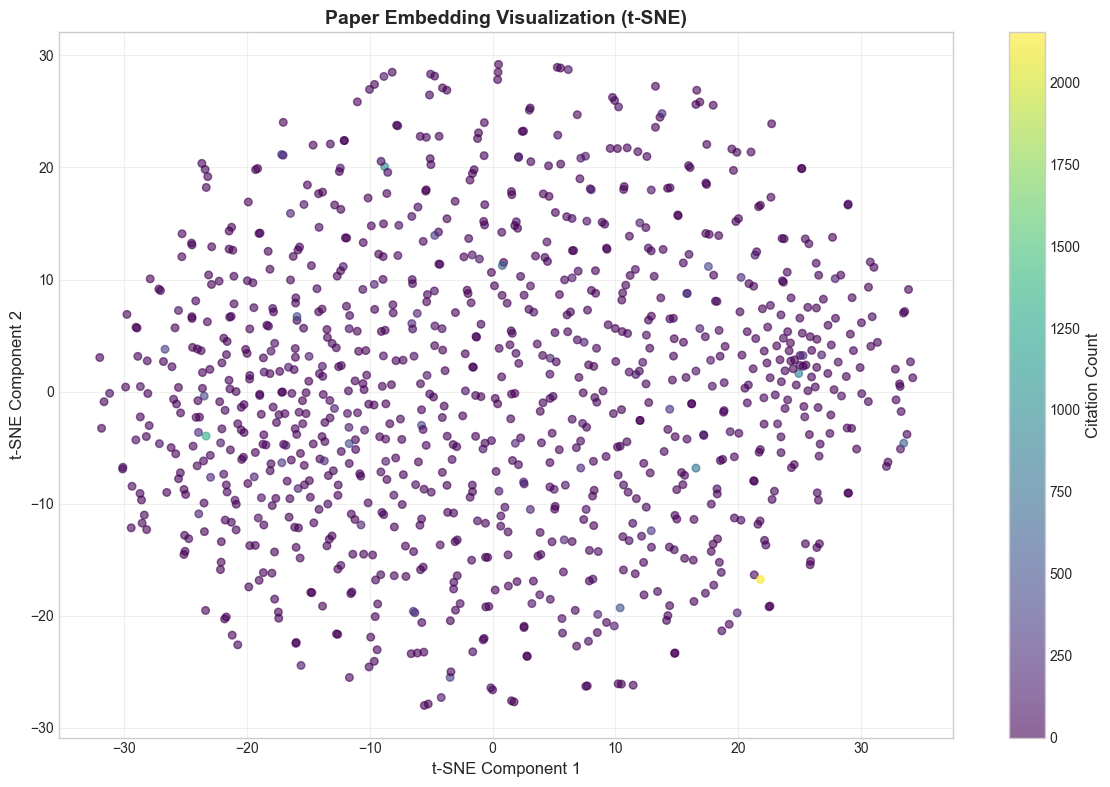

Embedding visualization saved to ../outputs/embedding_visualization.png


In [10]:
# Visualize learned embeddings in 2D
print("Creating embedding space visualization...")

# Get paper metadata for coloring
try:
    paper_metadata = extractor.get_paper_metadata()
    print(f"Loaded metadata for {len(paper_metadata)} papers")
except Exception as e:
    print(f"Could not load metadata: {e}")
    # Create dummy metadata
    paper_metadata = pd.DataFrame({
        'paper_id': list(entity_mapping.keys()),
        'citations': [0] * len(entity_mapping)
    })

# Get embeddings
with torch.no_grad():
    embeddings = trainer.model.entity_embeddings.weight.cpu()

# Sample embeddings for visualization (t-SNE is expensive)
sample_size = min(1000, len(embeddings))
sample_indices = torch.randperm(len(embeddings))[:sample_size]
sample_embeddings = embeddings[sample_indices]
sample_metadata = paper_metadata.iloc[sample_indices.numpy()] if len(paper_metadata) >= sample_size else paper_metadata

print(f"Visualizing {sample_size} embeddings with t-SNE...")

# Create embedding visualization
fig = plot_embedding_visualization(
    sample_embeddings,
    sample_metadata,
    method='tsne',
    figsize=(12, 8),
    save_path="../outputs/embedding_visualization.png"
)
plt.show()

print("Embedding visualization saved to ../outputs/embedding_visualization.png")

## 10. Model Confidence Analysis

In [11]:
# Analyze model confidence and prediction quality
print("Analyzing model confidence and prediction patterns...")

# Score distribution analysis
score_stats = predictions_df['score'].describe()
print(f"\n📊 Prediction Score Statistics:")
print(f"• Mean: {score_stats['mean']:.4f}")
print(f"• Std: {score_stats['std']:.4f}")
print(f"• Min: {score_stats['min']:.4f}")
print(f"• Max: {score_stats['max']:.4f}")

# High confidence predictions (lowest scores)
high_confidence = predictions_df[predictions_df['score'] <= predictions_df['score'].quantile(0.1)]
print(f"\n🎯 High Confidence Predictions (top 10%):")
print(f"• Count: {len(high_confidence):,}")
print(f"• Score threshold: {predictions_df['score'].quantile(0.1):.4f}")
print(f"• These represent the most likely missing citations")

# Papers with most predictions
source_counts = predictions_df['source_paper'].value_counts().head(10)
print(f"\n📝 Papers with Most Predictions:")
for paper, count in source_counts.items():
    short_title = paper[:80] + "..." if len(paper) > 80 else paper
    print(f"• {count:2d} predictions: {short_title}")

# Papers most frequently predicted as targets
target_counts = predictions_df['target_paper'].value_counts().head(10)
print(f"\n🎯 Most Frequently Predicted Target Papers:")
for paper, count in target_counts.items():
    short_title = paper[:80] + "..." if len(paper) > 80 else paper
    print(f"• {count:2d} predictions: {short_title}")

Analyzing model confidence and prediction patterns...

📊 Prediction Score Statistics:
• Mean: 13.5505
• Std: 1.1565
• Min: 10.2192
• Max: 16.3954

🎯 High Confidence Predictions (top 10%):
• Count: 100
• Score threshold: 12.0083
• These represent the most likely missing citations

📝 Papers with Most Predictions:
• 20 predictions: b6642aa74991318935f9e3a87dcf786fdc518a43
• 20 predictions: 8320d5384a1f9e509d1c72d1ad539f925c7141a0
• 20 predictions: c8f24405f8c110ce2665a0cddb8e8458824f3217
• 20 predictions: a3f474dc52a141d9f9b8131114636297ed4188e5
• 20 predictions: 2783d17e9ca4cba9526aae6ecb4c4cd1a3405568
• 20 predictions: 38537de90fda155cd10794c42dd6e14602b2fa77
• 20 predictions: 44d4ab43d016b8232247c14e60e513420164343c
• 20 predictions: f0857cee827c145a0af4d3485a83d331eaf6c8bc
• 20 predictions: edc8c2816cb3ecc8c87a71bc79fcac314ac55d6e
• 20 predictions: 1c15527047848a66a343428ae9e114421a883d2c

🎯 Most Frequently Predicted Target Papers:
• 43 predictions: c8de02ab86a69c099acd427db2e1797fc8d

## 11. Evaluation Summary and Insights

In [12]:
# Comprehensive evaluation summary
print("\n" + "="*70)
print("📊 COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)

print(f"\n🎯 Model Performance:")
print(f"   • Mean Reciprocal Rank: {results['mrr']:.4f} ({mrr_quality})")
print(f"   • Hits@1: {results['hits'][1]:.3f} ({results['hits'][1]*100:.1f}% top-1 accuracy)")
print(f"   • Hits@10: {results['hits'][10]:.3f} ({results['hits'][10]*100:.1f}% top-10 accuracy)")
print(f"   • AUC Score: {results['auc']:.4f} ({auc_quality})")

print(f"\n📋 Dataset Context:")
print(f"   • Test samples: {len(test_edges):,} ({len(test_pos_edges):,} positive, {len(test_neg_edges):,} negative)")
print(f"   • Entity vocabulary: {training_metadata['num_entities']:,} papers")
print(f"   • Network sparsity: {len(extractor.citation_edges) / (training_metadata['num_entities']**2):.6f}")

print(f"\n🔮 Prediction Generation:")
print(f"   • Generated predictions for {len(sample_papers)} papers")
print(f"   • Total predictions: {len(predictions_df):,}")
print(f"   • High-confidence predictions: {len(high_confidence):,}")
print(f"   • Score range: {predictions_df['score'].min():.4f} to {predictions_df['score'].max():.4f}")

print(f"\n💡 Key Insights:")
if results['hits'][1] > 0.1:
    print(f"   • Model successfully identifies missing citations with {results['hits'][1]*100:.1f}% top-1 accuracy")
else:
    print(f"   • Model struggles with precise ranking (low Hits@1)")

if results['auc'] > 0.8:
    print(f"   • Strong discrimination between citations and non-citations")
else:
    print(f"   • Moderate ability to distinguish citations from non-citations")

print(f"   • Average predicted rank for true citations: {1/results['mrr']:.1f}")
print(f"   • Model learned meaningful embeddings in {training_metadata['embedding_dim']}D space")

print(f"\n📁 Generated Files:")
print(f"   • ../outputs/evaluation_results.png - Performance metrics visualization")
print(f"   • ../outputs/prediction_analysis.png - Prediction analysis plots")
print(f"   • ../outputs/embedding_visualization.png - t-SNE embedding visualization")
print(f"   • ../outputs/citation_predictions.csv - All citation predictions")

print(f"\n🎓 Research Value:")
print(f"   • {len(high_confidence):,} high-confidence missing citations identified")
print(f"   • Demonstrates feasibility of ML-based citation recommendation")
print(f"   • Embeddings capture semantic relationships between papers")
print(f"   • Ready for notebook 04_story_visualization.ipynb")

print("\n✅ Prediction analysis complete! Model evaluation successful.")


📊 COMPREHENSIVE EVALUATION SUMMARY

🎯 Model Performance:
   • Mean Reciprocal Rank: 0.1118 (Fair)
   • Hits@1: 0.036 (3.6% top-1 accuracy)
   • Hits@10: 0.261 (26.1% top-10 accuracy)
   • AUC Score: 0.9845 (Excellent discrimination)

📋 Dataset Context:
   • Test samples: 7,566 (3,783 positive, 3,783 negative)
   • Entity vocabulary: 12,553 papers
   • Network sparsity: 0.000120

🔮 Prediction Generation:
   • Generated predictions for 50 papers
   • Total predictions: 1,000
   • High-confidence predictions: 100
   • Score range: 10.2192 to 16.3954

💡 Key Insights:
   • Model struggles with precise ranking (low Hits@1)
   • Strong discrimination between citations and non-citations
   • Average predicted rank for true citations: 8.9
   • Model learned meaningful embeddings in 128D space

📁 Generated Files:
   • ../outputs/evaluation_results.png - Performance metrics visualization
   • ../outputs/prediction_analysis.png - Prediction analysis plots
   • ../outputs/embedding_visualization.p

In [13]:
# Save evaluation results for story visualization
eval_summary = {
    'metrics': evaluation_results,
    'training_metadata': training_metadata,
    'prediction_stats': {
        'total_predictions': len(predictions_df),
        'high_confidence': len(high_confidence),
        'sample_papers': len(sample_papers),
        'score_range': (predictions_df['score'].min(), predictions_df['score'].max())
    },
    'interpretation': {
        'mrr_quality': mrr_quality,
        'auc_quality': auc_quality,
        'overall_assessment': overall
    }
}

with open('../outputs/evaluation_summary.pkl', 'wb') as f:
    pickle.dump(eval_summary, f)

print("Evaluation summary saved for story visualization.")

# Clean up
db.close()
if device.type == 'cuda':
    torch.cuda.empty_cache()

print("\nCleanup complete. Ready for story visualization!")

Evaluation summary saved for story visualization.

Cleanup complete. Ready for story visualization!
